In [58]:
from pyedflib import highlevel
import numpy as np
np.warnings.filterwarnings('ignore')
from pylab import *
import csv
from scipy import signal
from scipy.stats import *
import pandas as pd
import seaborn
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

In [59]:
class Register:
    
    def __init__(self, name, fs, nseizures):
        self.name = name
        self.fs = fs
        self.nseizures = nseizures
        self.seizures = []
            
    def addSeizure (self, start, end):
        seizure = (start, end)
        self.seizures.append(seizure)

In [79]:
def frec2sample_range(fi, fo, fs, N):
    si = max(1,floor(fi*N/fs))
    so = ceil(fo*N/fs)
    return int(si), int(so)

def band_energy(fft, fs):
    N = len(fft)
    # Energia total
    et = sum(fft)
    dsi, dso = frec2sample_range(0.5, 4, fs, N)
    d = sum(fft[dsi:dso])
    tsi, tso = frec2sample_range(4, 7, fs, N)
    t = sum(fft[tsi:tso])
    asi, aso = frec2sample_range(7, 13, fs, N)
    a = sum(fft[asi:aso])
    bsi, bso = frec2sample_range(13, 30, fs, N)
    b = sum(fft[bsi:bso])
    gsi, gso = frec2sample_range(30, 50, fs, N)
    g = sum(fft[gsi:gso])
    return et, d, t, a, b, g

def psd(signal):
    X = fft(signal)
    Px = real(X*conj(X))
    return Px

def exponential_smooth(timeseries, alpha=0.3):
    model = SimpleExpSmoothing(timeseries)
    fit = model.fit(smoothing_level=alpha)
    return fit.fittedvalues

def spectral_centroid(nf, ps):
    return sum(nf * ps)

def variational_coeff(nf, ps, sc):
    return sum( (((nf - sc))**2) * ps) / sum(ps)

def spectral_skew(nf, ps, sc, vc):
    return sum( ((nf - sc)/vc)**3 * ps) / sum(ps)

def normalize(signal, boolean = False):
    if boolean == True:
        return (signal-mean(signal))/max(signal)
    else:
        return (signal)/max(signal)
    

def chunk_processing(chunk, fs):
    
    ninstances = chunk.shape[0]
    et = zeros(ninstances)
    d = zeros(ninstances)
    t = zeros(ninstances)
    a = zeros(ninstances)
    b = zeros(ninstances)
    g = zeros(ninstances)
    
    meanv = zeros(ninstances)
    variancev = zeros(ninstances)
    skewnessv = zeros(ninstances)
    kurtosisv = zeros(ninstances)
    stdv = zeros(ninstances)
    zcrossingsv = zeros(ninstances)
    p2pv = zeros(ninstances)
    
    spectralCentroid = zeros(ninstances)
    variationalCoeff = zeros(ninstances)
    spectralSkew = zeros(ninstances)
    
    #df = pd.DataFrame()
    features = ['mean', 'variance', 'skewness', 'kurtosis', 'std', 'zero_crossings', 'peak2peak',
                'total_energy', 'delta', 'theta', 'alpha', 'beta', 'gamma',
                'delta/theta', 'delta/alpha', 'delta/beta', 'delta/gamma', 'theta/alpha', 'theta/beta', 'theta/gamma',
                'alpha/beta', 'alpha/gamma', 'beta/gamma',
                'spectral_centroid', 'variatonial_coeff', 'spectral_skew']
    
    indexStart = chunk.index[0]
    for index, row in chunk.iterrows():
        index = index - indexStart
        signal = row[0:512].values
        
        meanv[index] = mean(signal)
        variancev[index] = var(signal)
        skewnessv[index] = skew(signal)
        kurtosisv[index] = kurtosis(signal)
        stdv[index] = std(signal)
        zcrossingsv[index] = len(np.where(np.diff(np.sign(signal)))[0])
        p2pv[index] = max(signal)-min(signal)
        
        Px = psd(signal)
        et[index], d[index], t[index], a[index], b[index], g[index] = band_energy(Px, fs)

        
        p_spectrum = Px[:len(Px)//2]/sum(Px[:len(Px)//2])
        normalized_f = linspace(0, 1, len(Px)//2)
        spectralCentroid[index] = spectral_centroid(normalized_f, p_spectrum)
        variationalCoeff[index] = variational_coeff(normalized_f, p_spectrum, spectralCentroid[index])
        spectralSkew[index] = spectral_skew(normalized_f, p_spectrum, spectralCentroid[index], variationalCoeff[index])

    dt = d/t 
    da = d/a 
    db = d/b 
    dg = d/g 
    ta = t/a 
    tb = t/b
    tg = t/g
    ab = a/b
    ag = a/g
    bg = b/g
        
    data = [exponential_smooth(normalize(meanv)), exponential_smooth(normalize(variancev)), exponential_smooth(normalize(skewnessv)),
            exponential_smooth(normalize(kurtosisv)), exponential_smooth(normalize(stdv)),exponential_smooth(normalize(zcrossingsv)),exponential_smooth(normalize(p2pv)),
            
            exponential_smooth(normalize(et)), exponential_smooth(normalize(d)), exponential_smooth(normalize(t)),
            exponential_smooth(normalize(a)), exponential_smooth(normalize(b)),exponential_smooth(normalize(g)),
        
            exponential_smooth(normalize(dt)), exponential_smooth(normalize(da)),exponential_smooth(normalize(db)),
            exponential_smooth(normalize(dg)), exponential_smooth(normalize(ta)),exponential_smooth(normalize(tb)),
            exponential_smooth(normalize(tg)), exponential_smooth(normalize(ab)),exponential_smooth(normalize(ag)),
            exponential_smooth(normalize(bg)),
        
            exponential_smooth(normalize(spectralCentroid)),exponential_smooth(normalize(variationalCoeff)), exponential_smooth(normalize(spectralSkew))
    ]
                                                                  
        
    data = np.array(data).transpose()
    df = pd.DataFrame(data, columns = features)
    df['seizure'] = pd.Series(chunk['seizure'].values, index = df.index)
        
    return df


In [61]:
import glob, os

basedir = os.getcwd()
dbdir = "E:\Master\TFM\chb-mit-scalp-eeg-database-1.0.0\chb01"

In [64]:
os.chdir(dbdir)
annotation = glob.glob('*txt')

with open(annotation[0]) as f:
    registers = {}
    for line in f:
        if ("Data Sampling Rate" in line):
            line = line.split()
            fs = int(line[3])
        elif ("File Name" in line):
            name = line.split()[2]
            while True:
                newLine = f.readline()
                if ("Number of Seizures" in newLine):
                    nseizures = int(newLine.split()[5])
                    register = Register(name, fs, nseizures)
                    if nseizures > 0:
                        for i in range(nseizures):
                            line1 = f.readline().split()
                            line2 = f.readline().split()
                            if (line1[3] == "Time:"):
                                start = int(line1[4])
                                end = int(line2[4])
                            else:
                                start = int(line1[3])
                                end = int(line2[3])
                            register.addSeizure(start, end)
                            
                    registers[name] = register
                    break

os.chdir(basedir)                 

In [65]:
register = registers['chb01_04.edf']

In [66]:
fs = 256
timeW = 2
N = timeW*fs

# Signal reading
signals, signal_headers, header = highlevel.read_edf(dbdir + '\chb01_04.edf')
signals = np.float16(signals)
# Truncate to obtain windows
samples = signals.shape[1]
nw = int(samples//N)
signals = signals[:, 0:nw*N]
samples = signals.shape[1]
time = np.linspace(0, signals.shape[1]/fs, signals.shape[1])

# Seizure vector creation
seizure = zeros(samples)
if (len(register.seizures) > 0):
    for n in range (len(register.seizures)):
        start = register.seizures[n][0]*fs
        end = register.seizures[n][1]*fs
        seizure[start:end] = np.ones(end-start)

seizureW = np.reshape(seizure, [nw, N])
seizureW = (sum(seizureW, 1) > N//2)

In [67]:
sum(seizureW)

13

In [68]:
len(register.seizures)

1

In [69]:
basedir

'E:\\Master\\TFM\\Codigo\\Jupiter\\Test_EEG\\SignalsStudy'

In [70]:
# Create list for feature names
features = []
for i in range(N):
    features.append("sample" + str(i+1))
    
df = pd.DataFrame()
for channel, signal in enumerate(signals):
    newSignal = np.reshape(signal, [nw, N])
    newdf = pd.DataFrame(newSignal, columns = features)
    newdf['seizure'] = pd.Series( seizureW, index = newdf.index)
    df = df.append(newdf, ignore_index=True)
    

df.to_hdf(basedir + '\example.h5', key = 'example', mode = 'w', format = 'table')


[31. 39. 34. ... 61. 47. 44.]


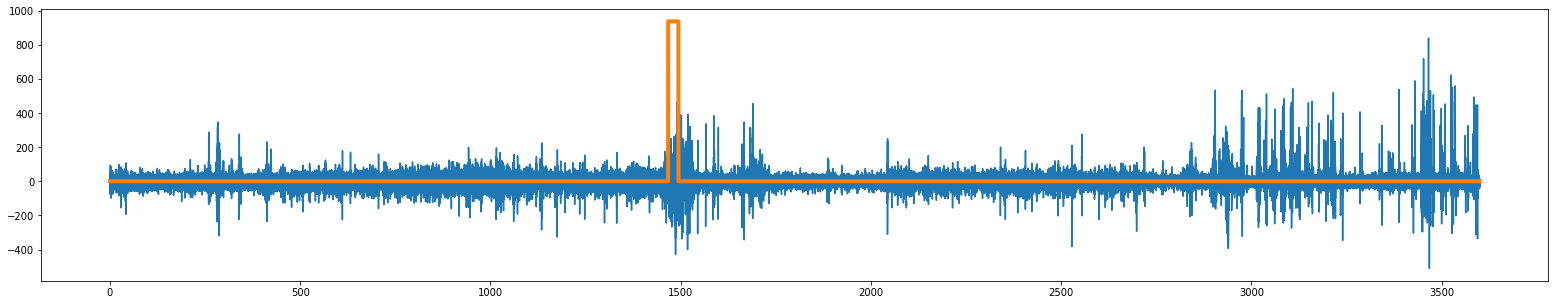

<Figure size 432x288 with 0 Axes>

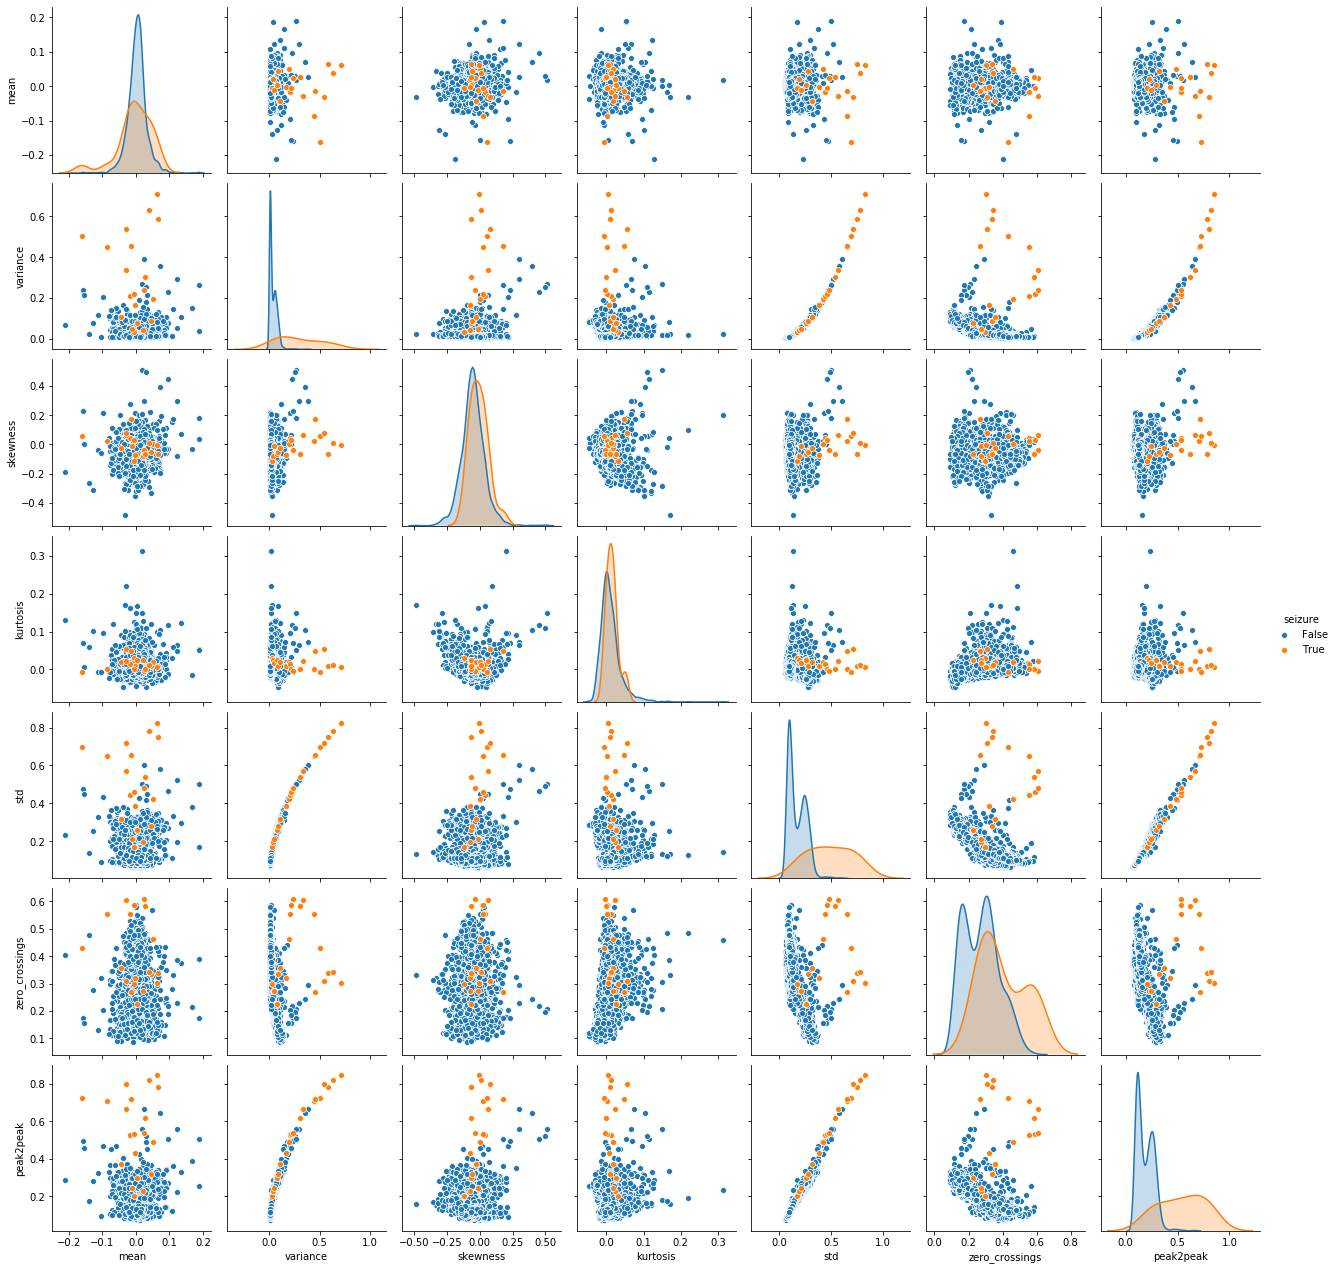

<Figure size 432x288 with 0 Axes>

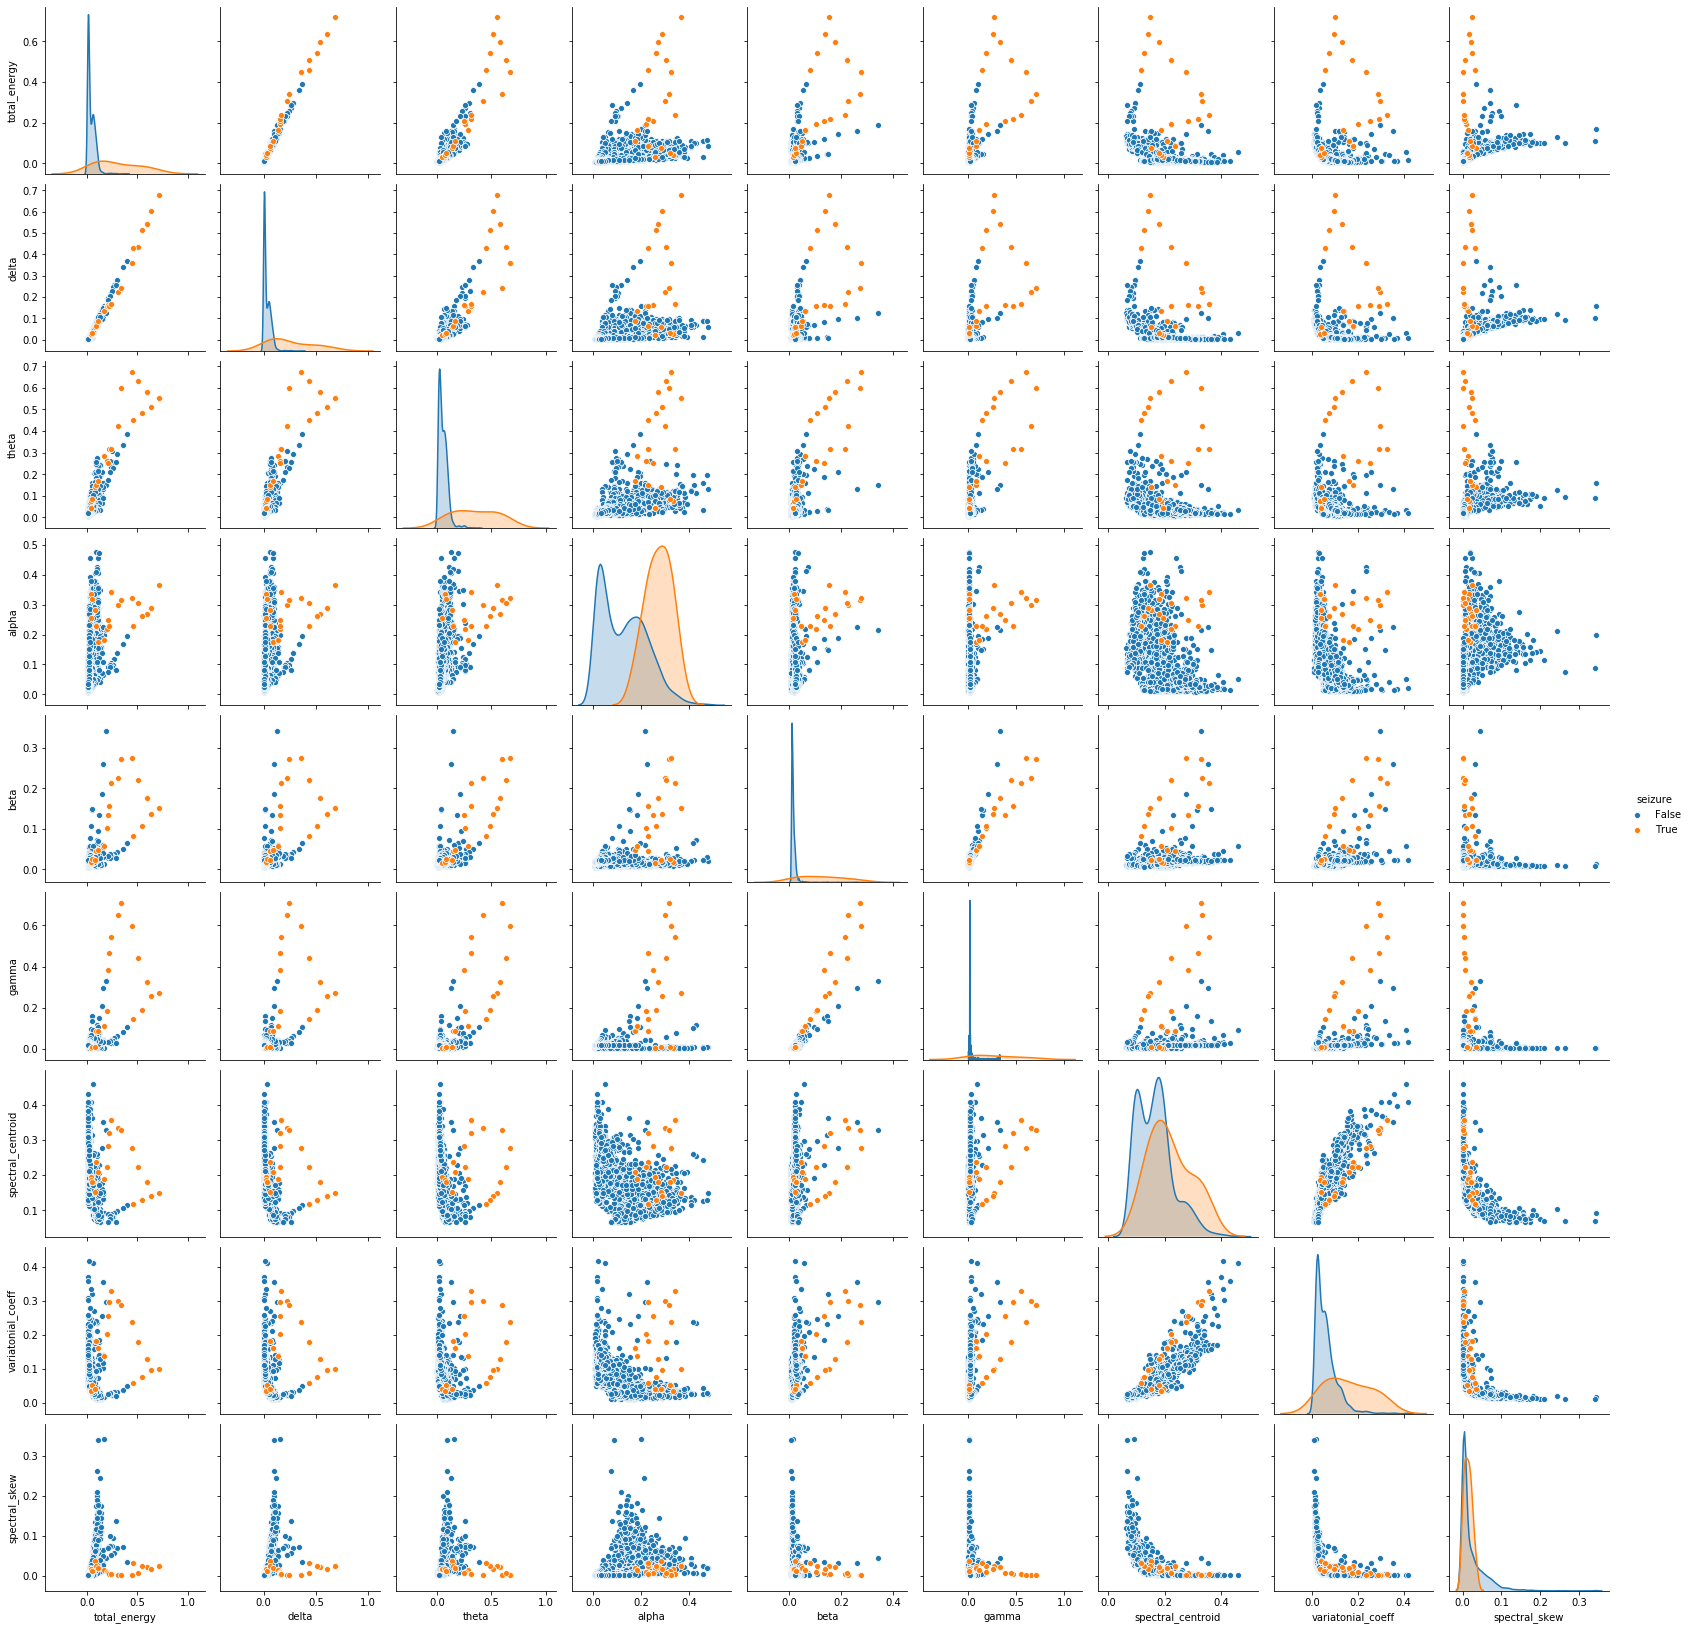

<Figure size 432x288 with 0 Axes>

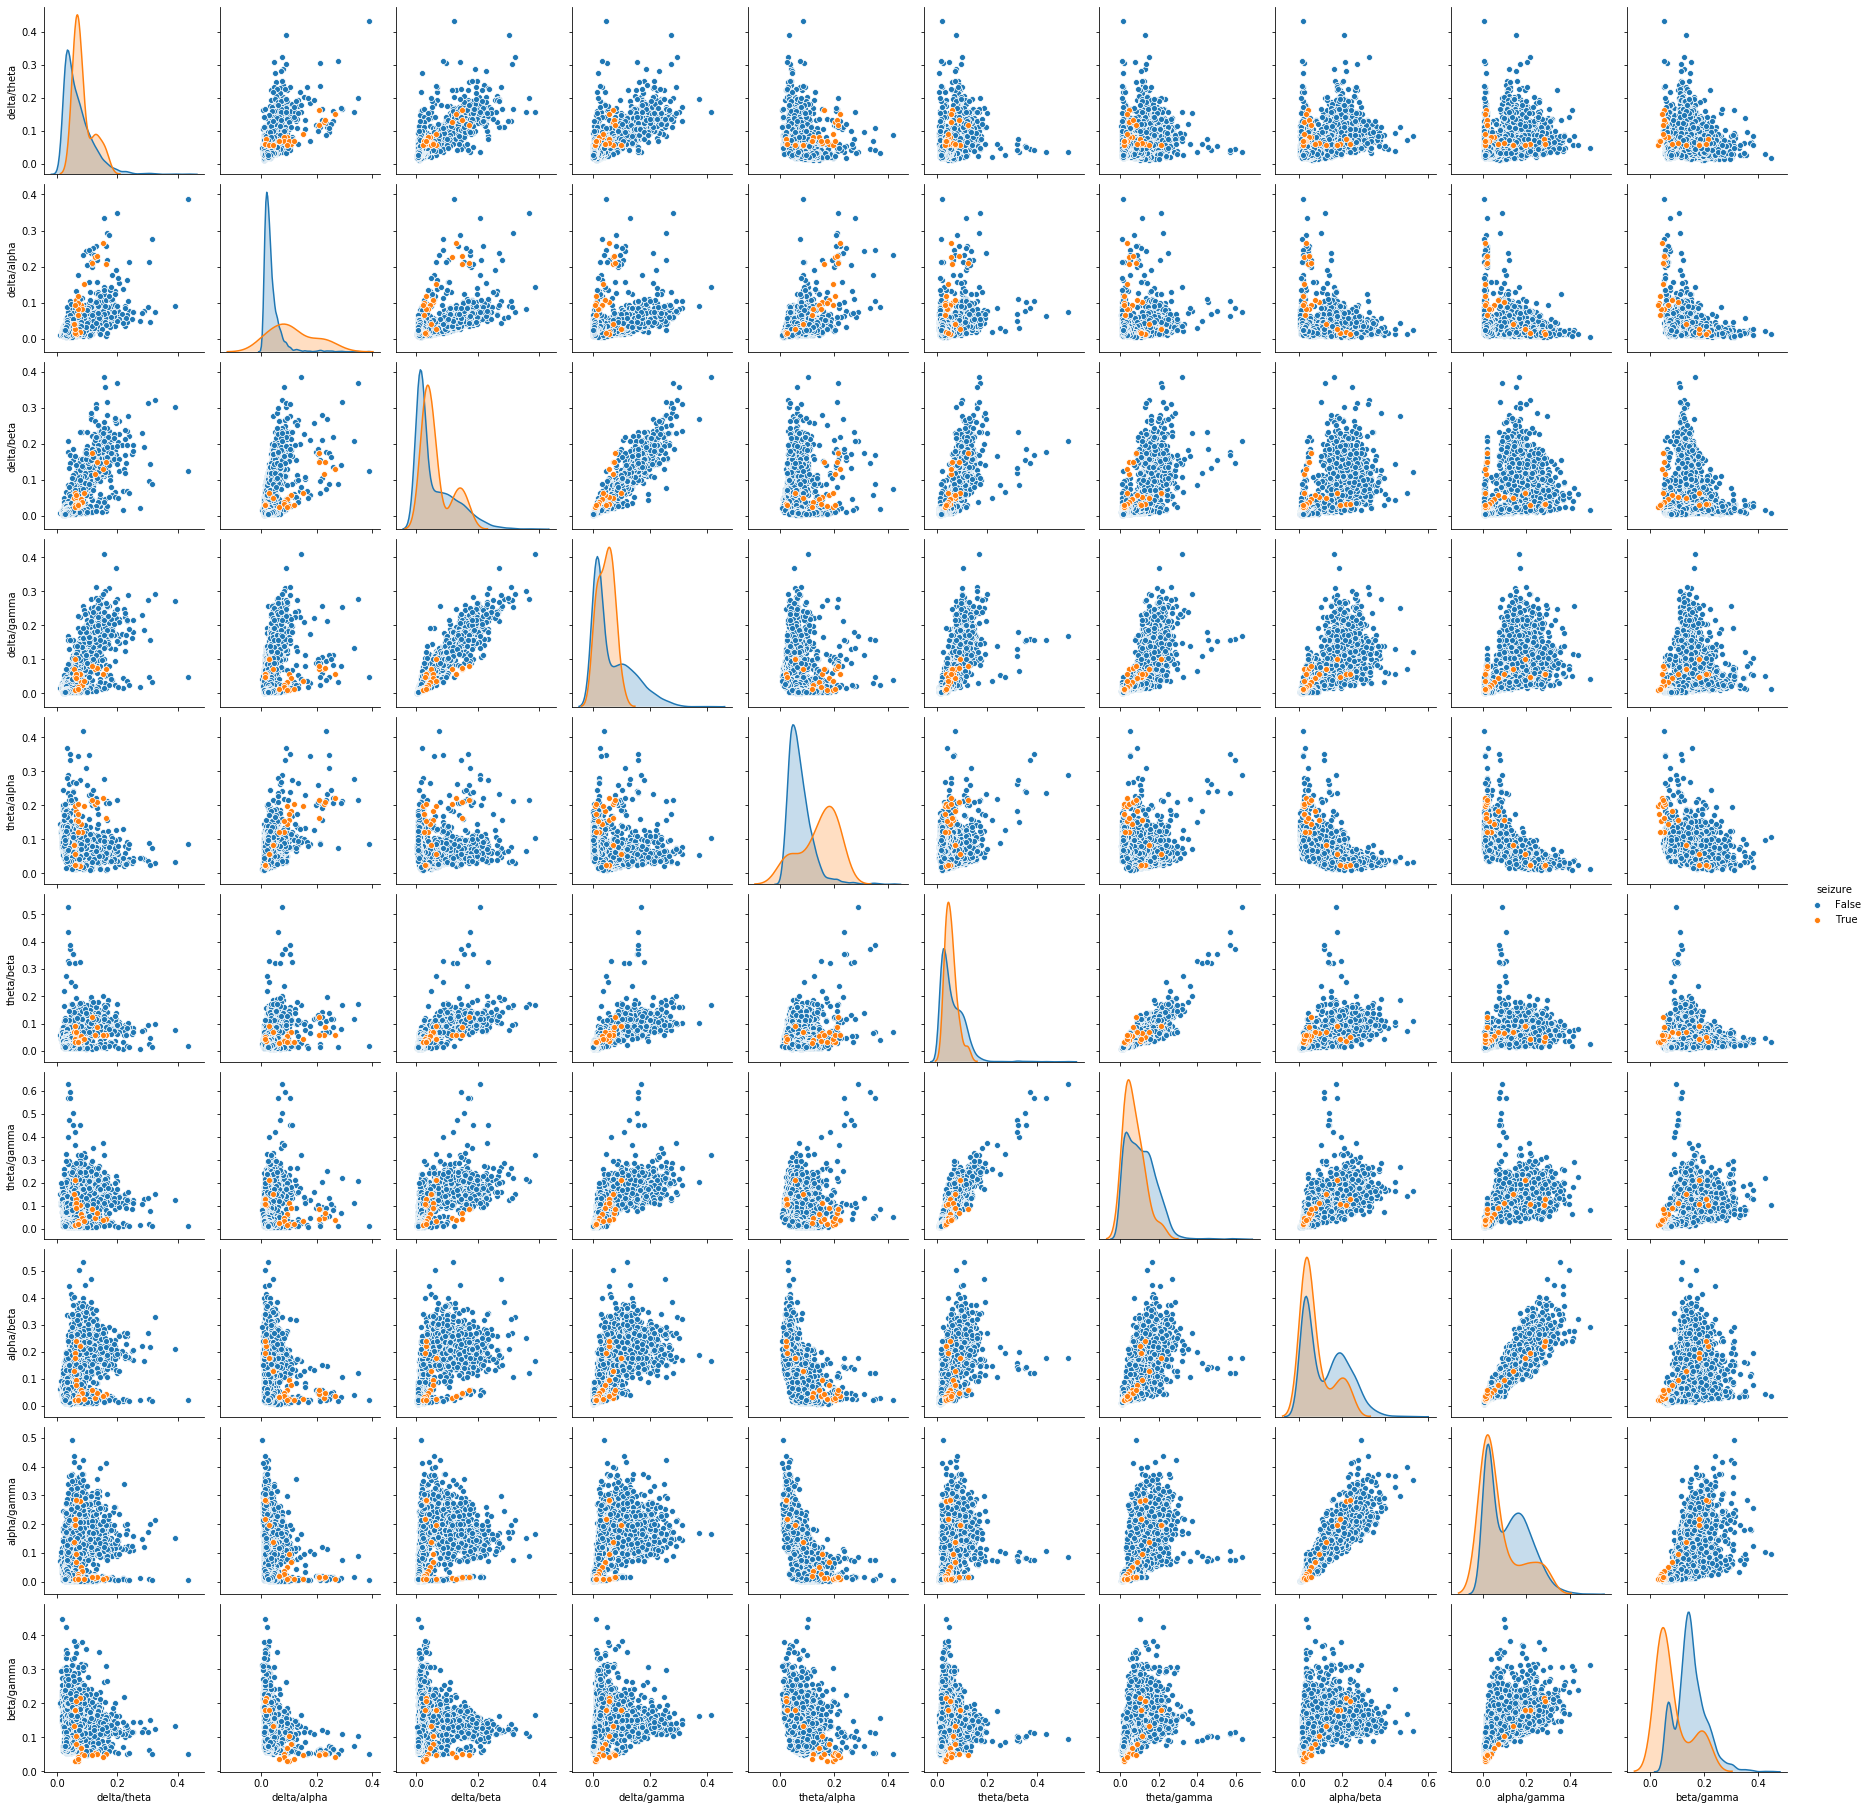

[29. 32. 25. ... 31. 40. 22.]


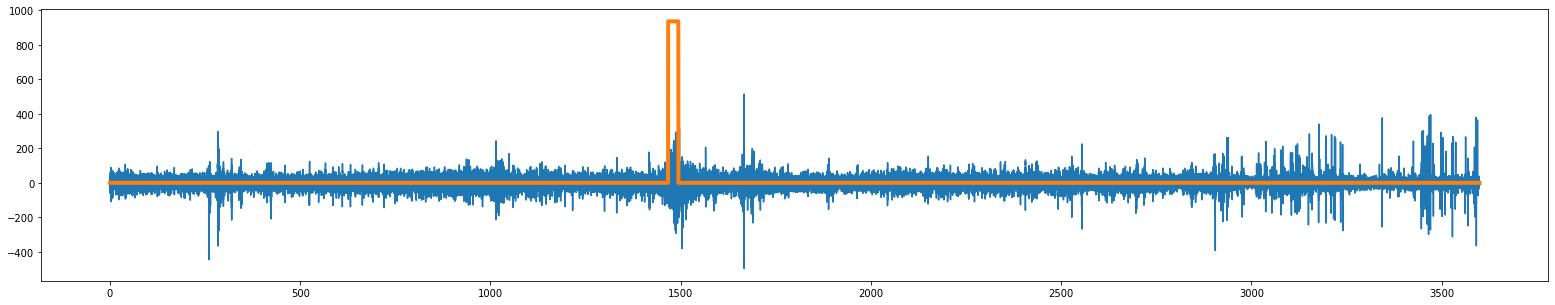

<Figure size 432x288 with 0 Axes>

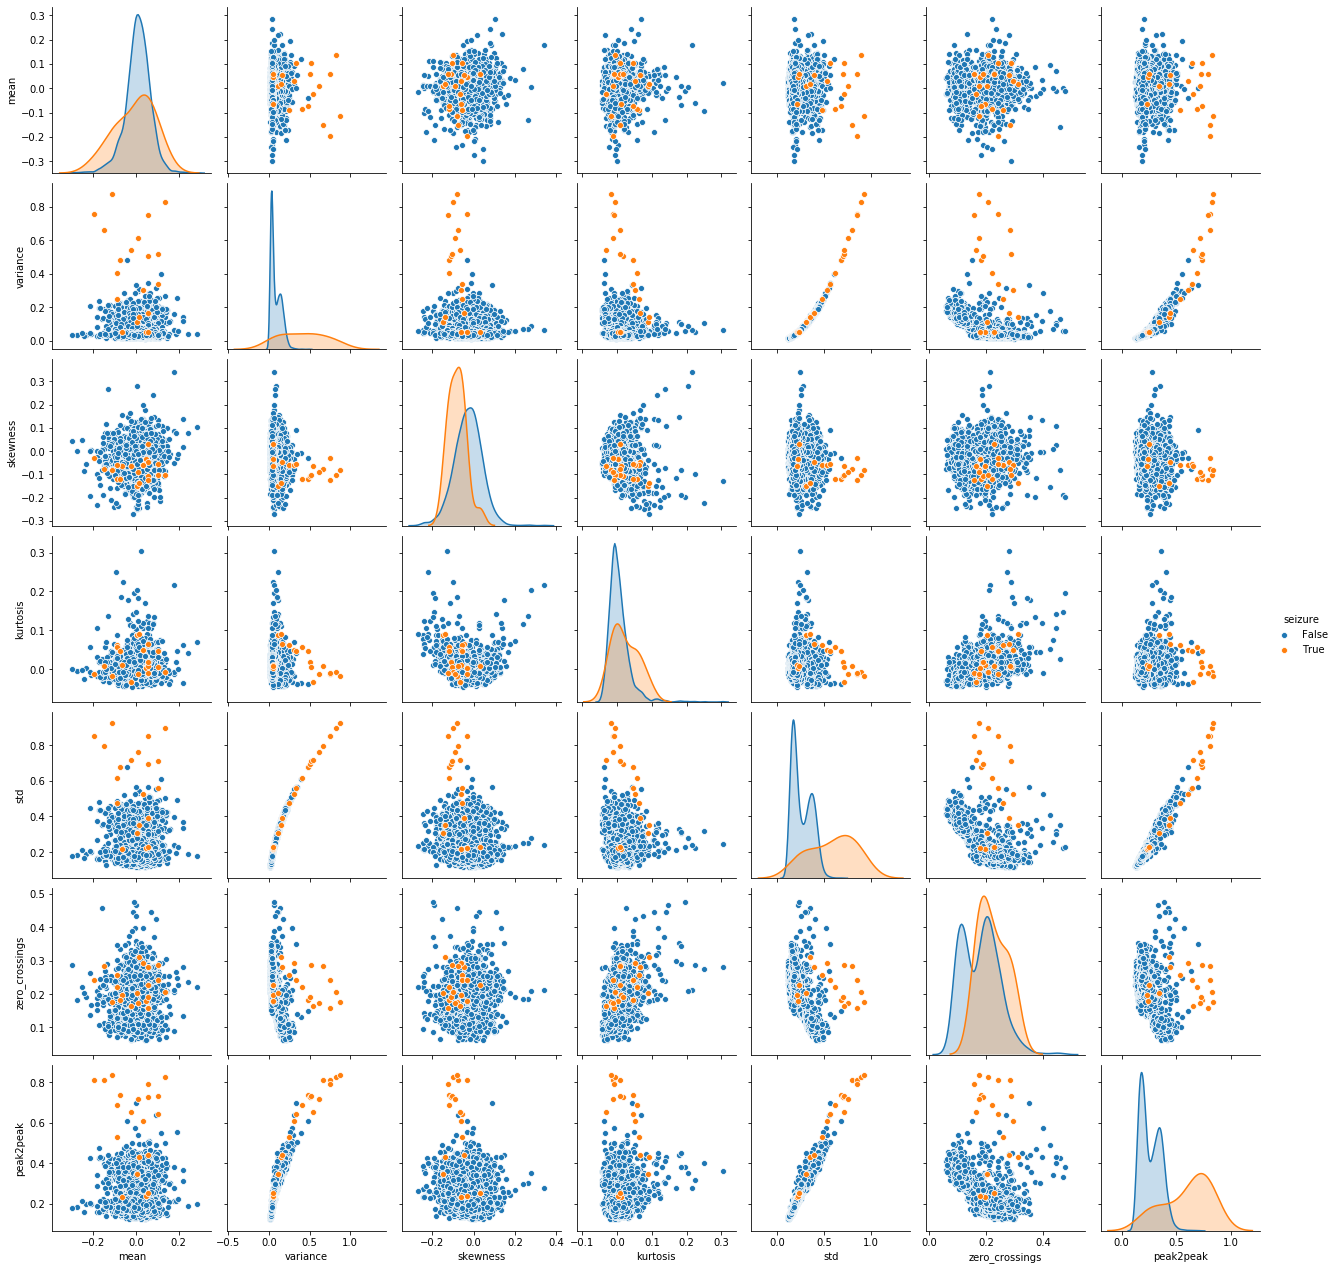

<Figure size 432x288 with 0 Axes>

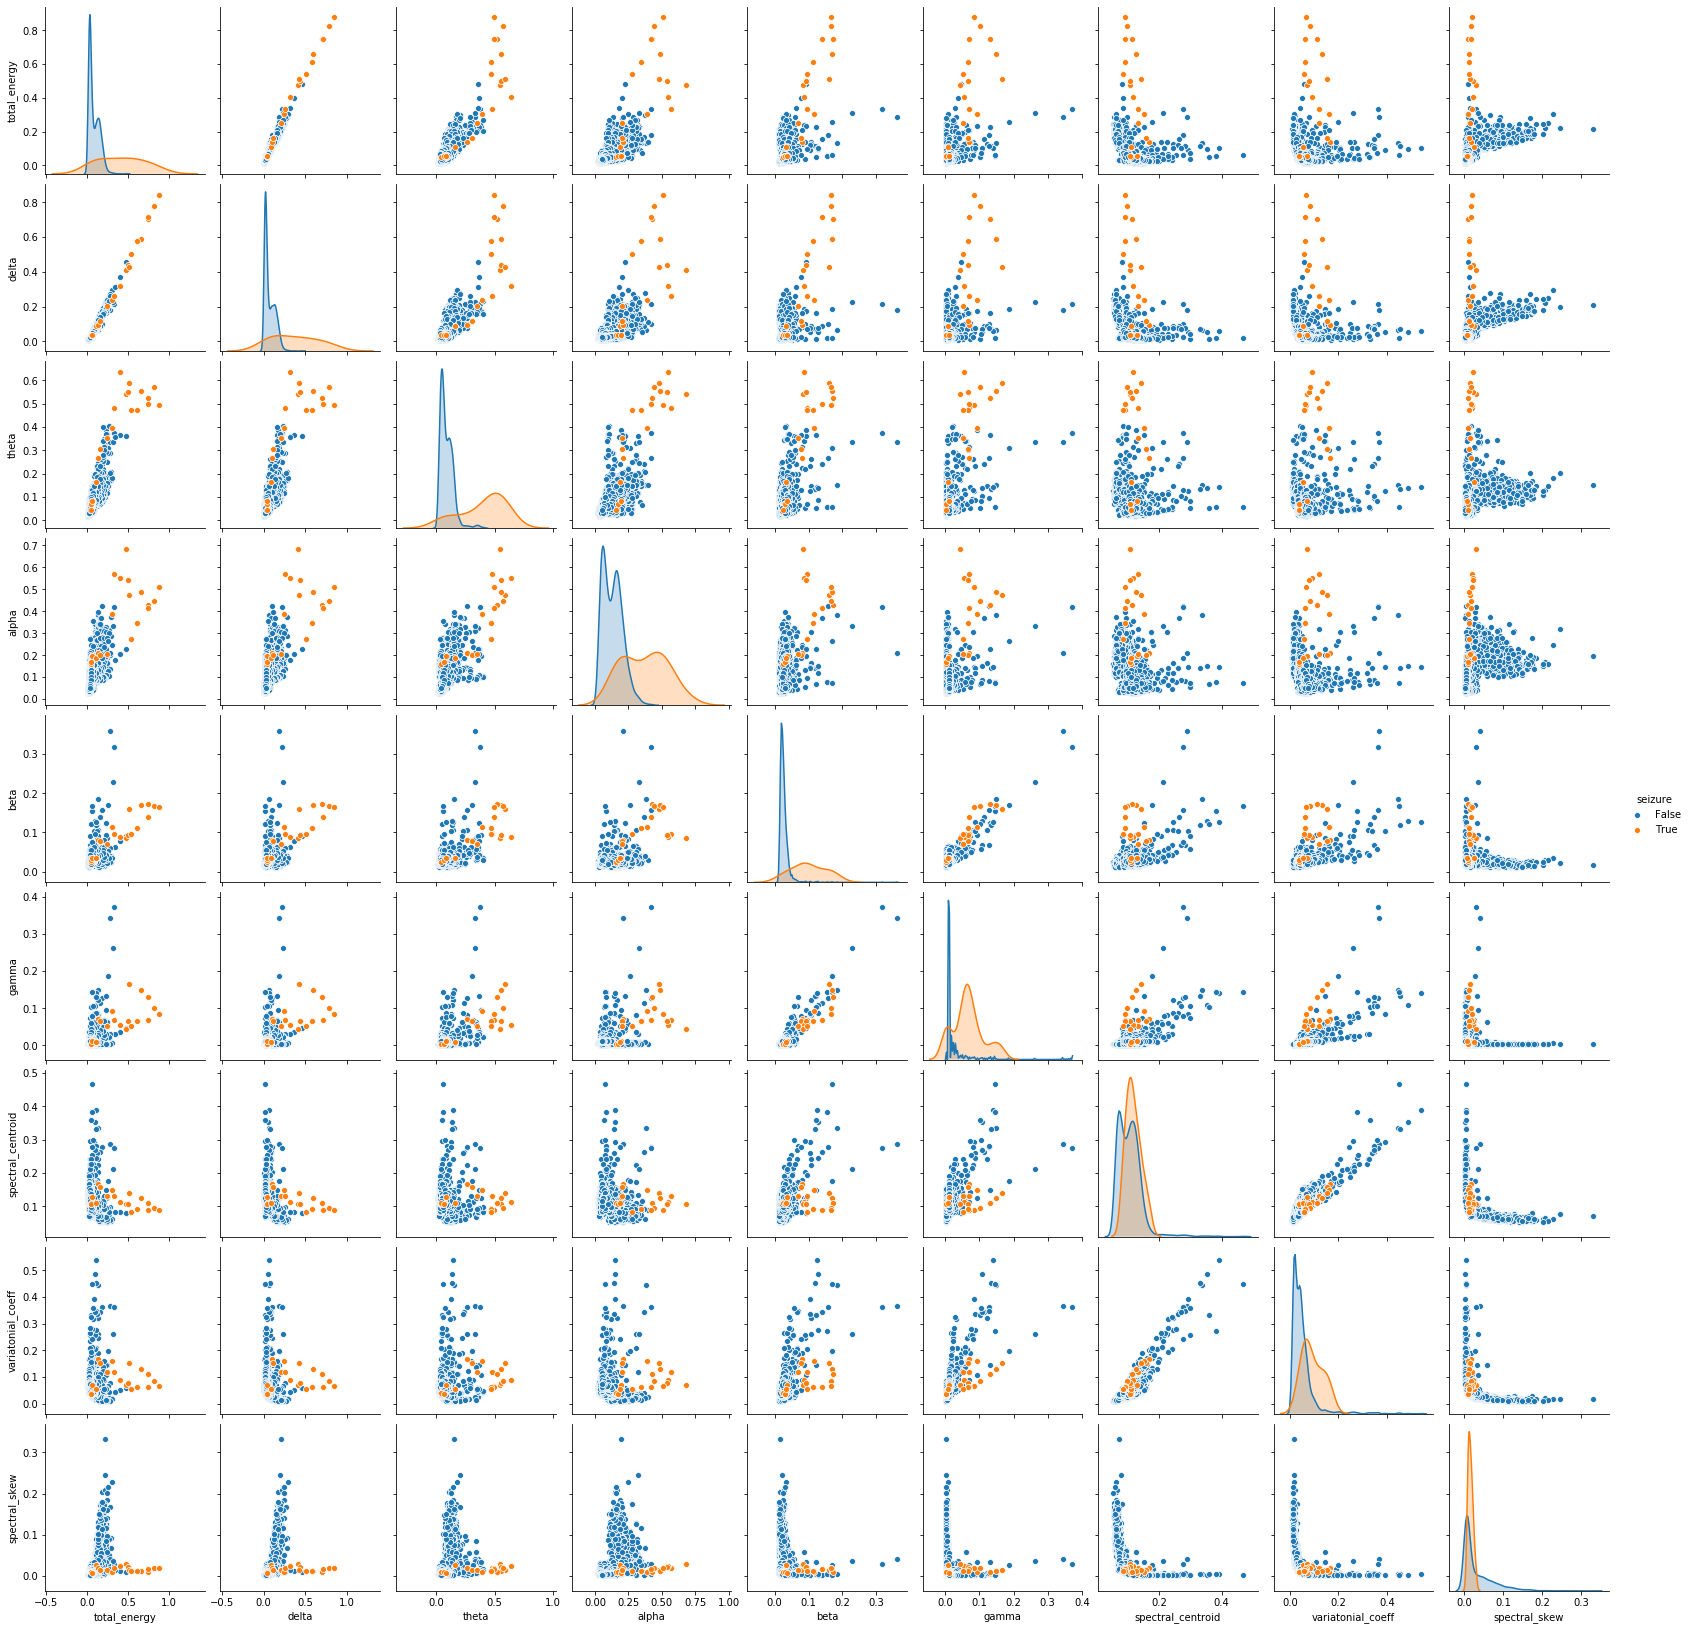

<Figure size 432x288 with 0 Axes>

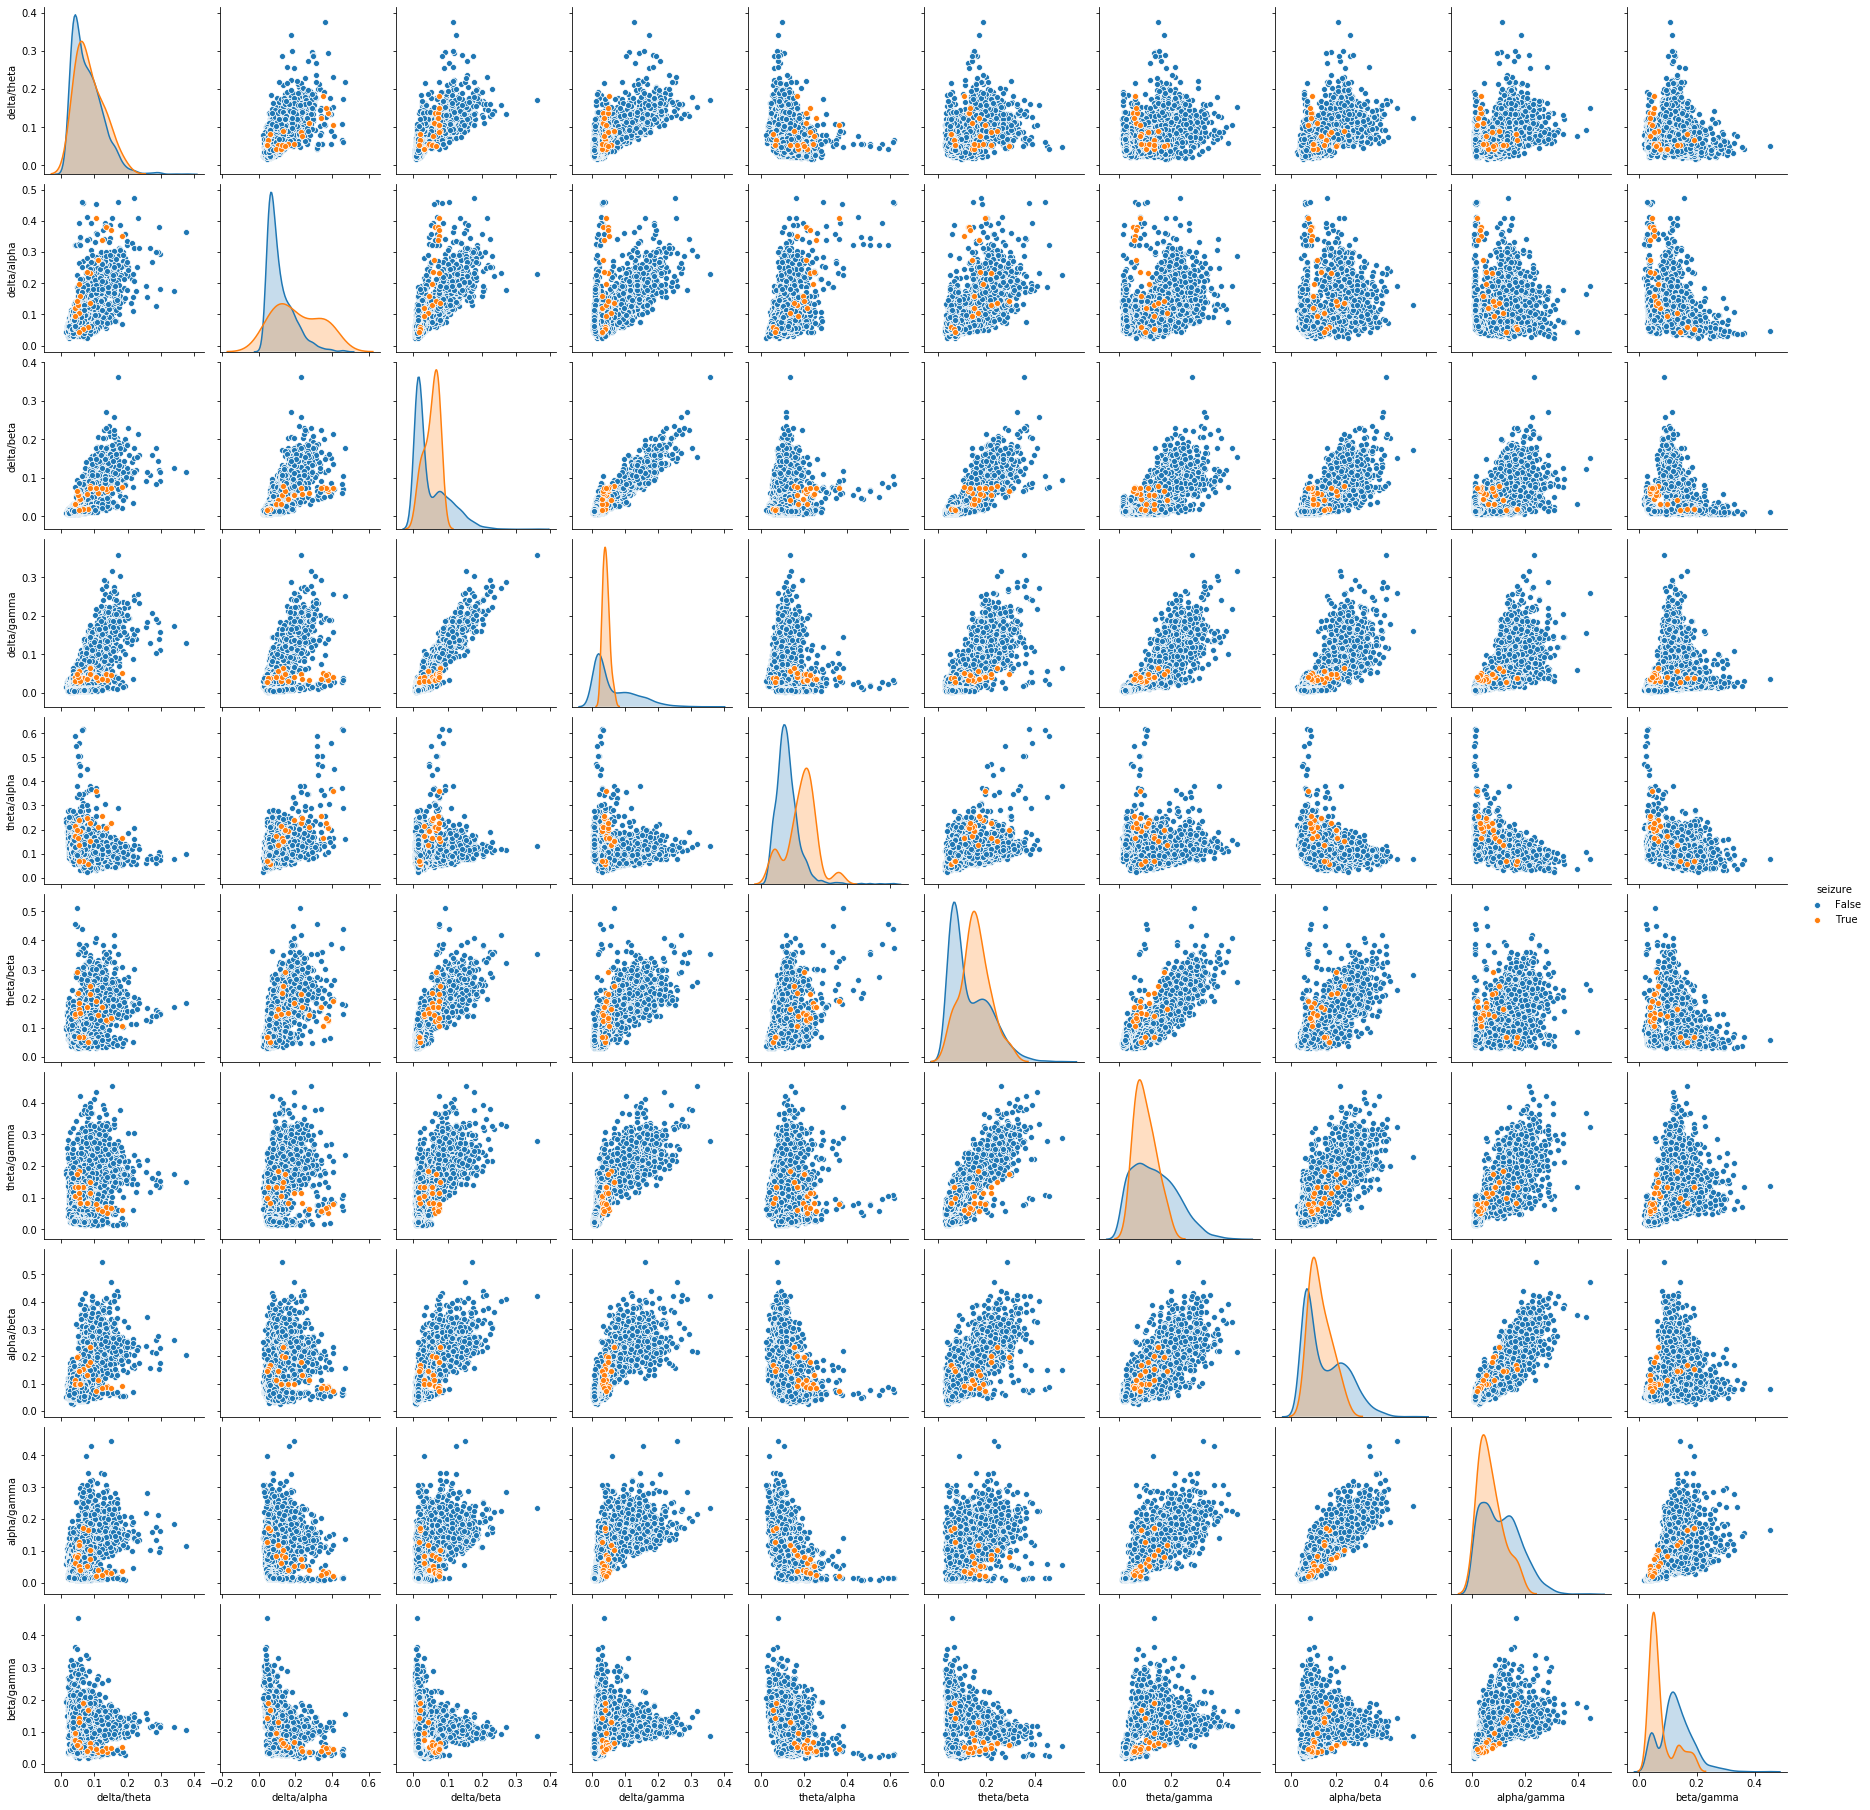

[16. 21. 34. ... 26. 30. 28.]


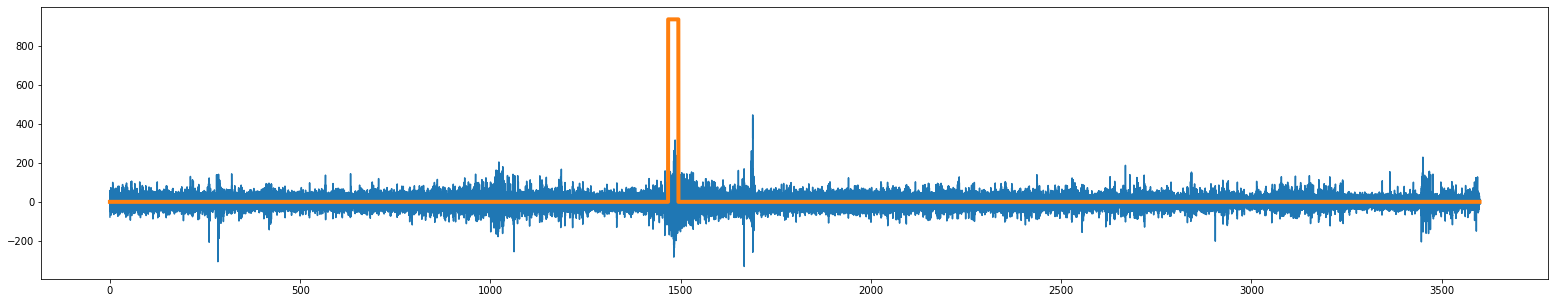

<Figure size 432x288 with 0 Axes>

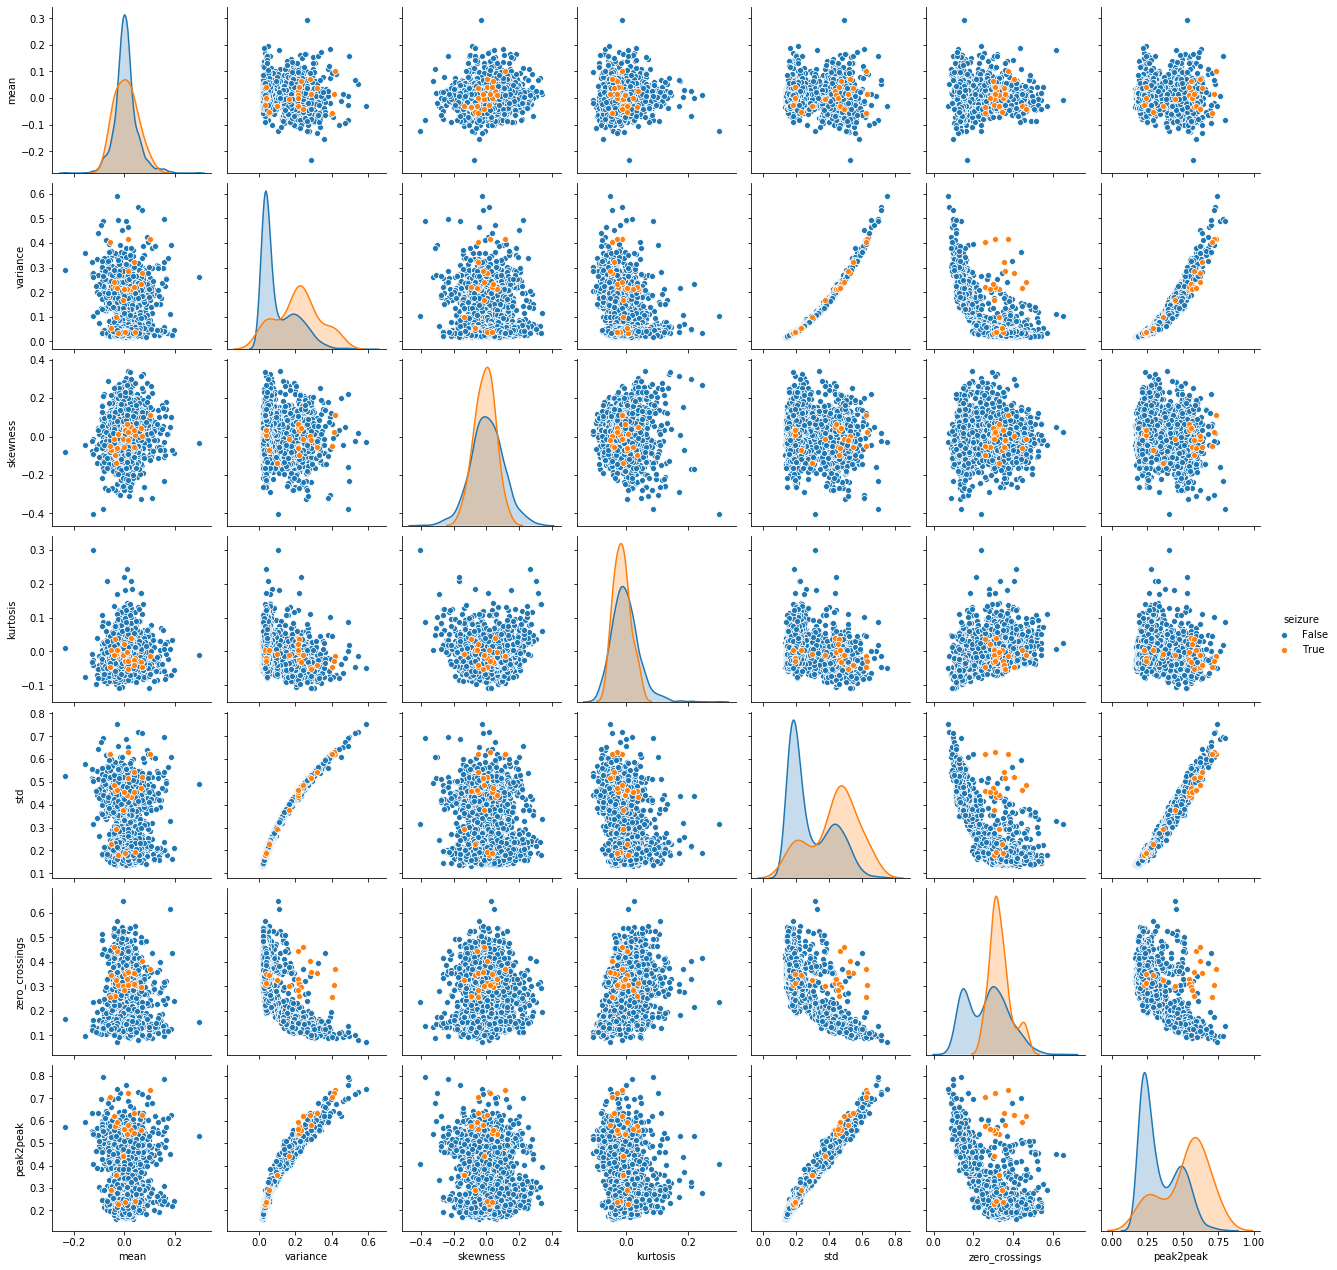

<Figure size 432x288 with 0 Axes>

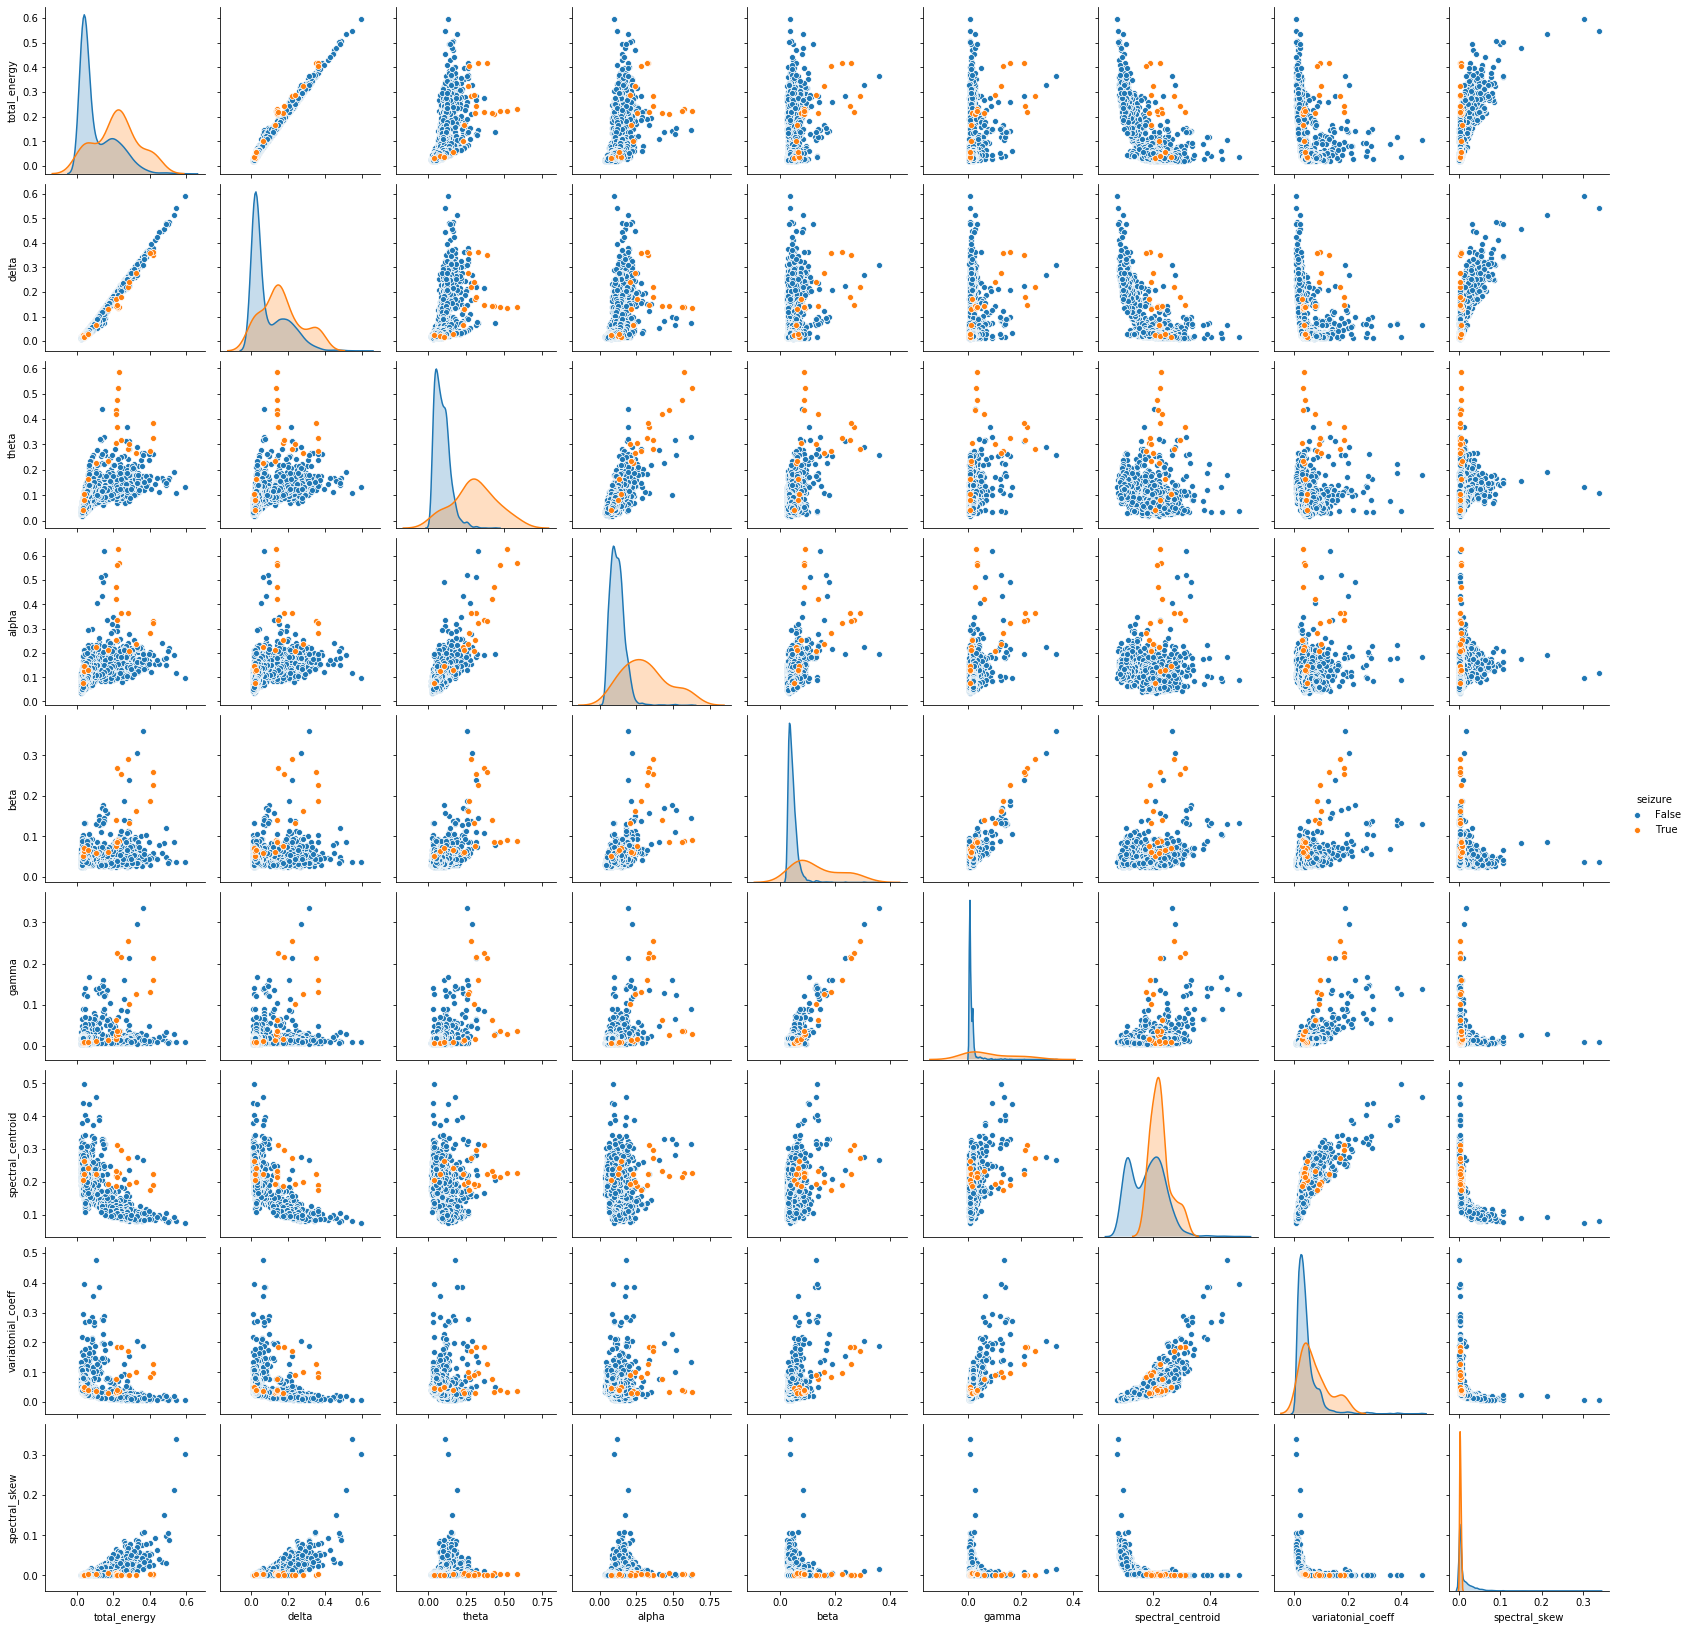

<Figure size 432x288 with 0 Axes>

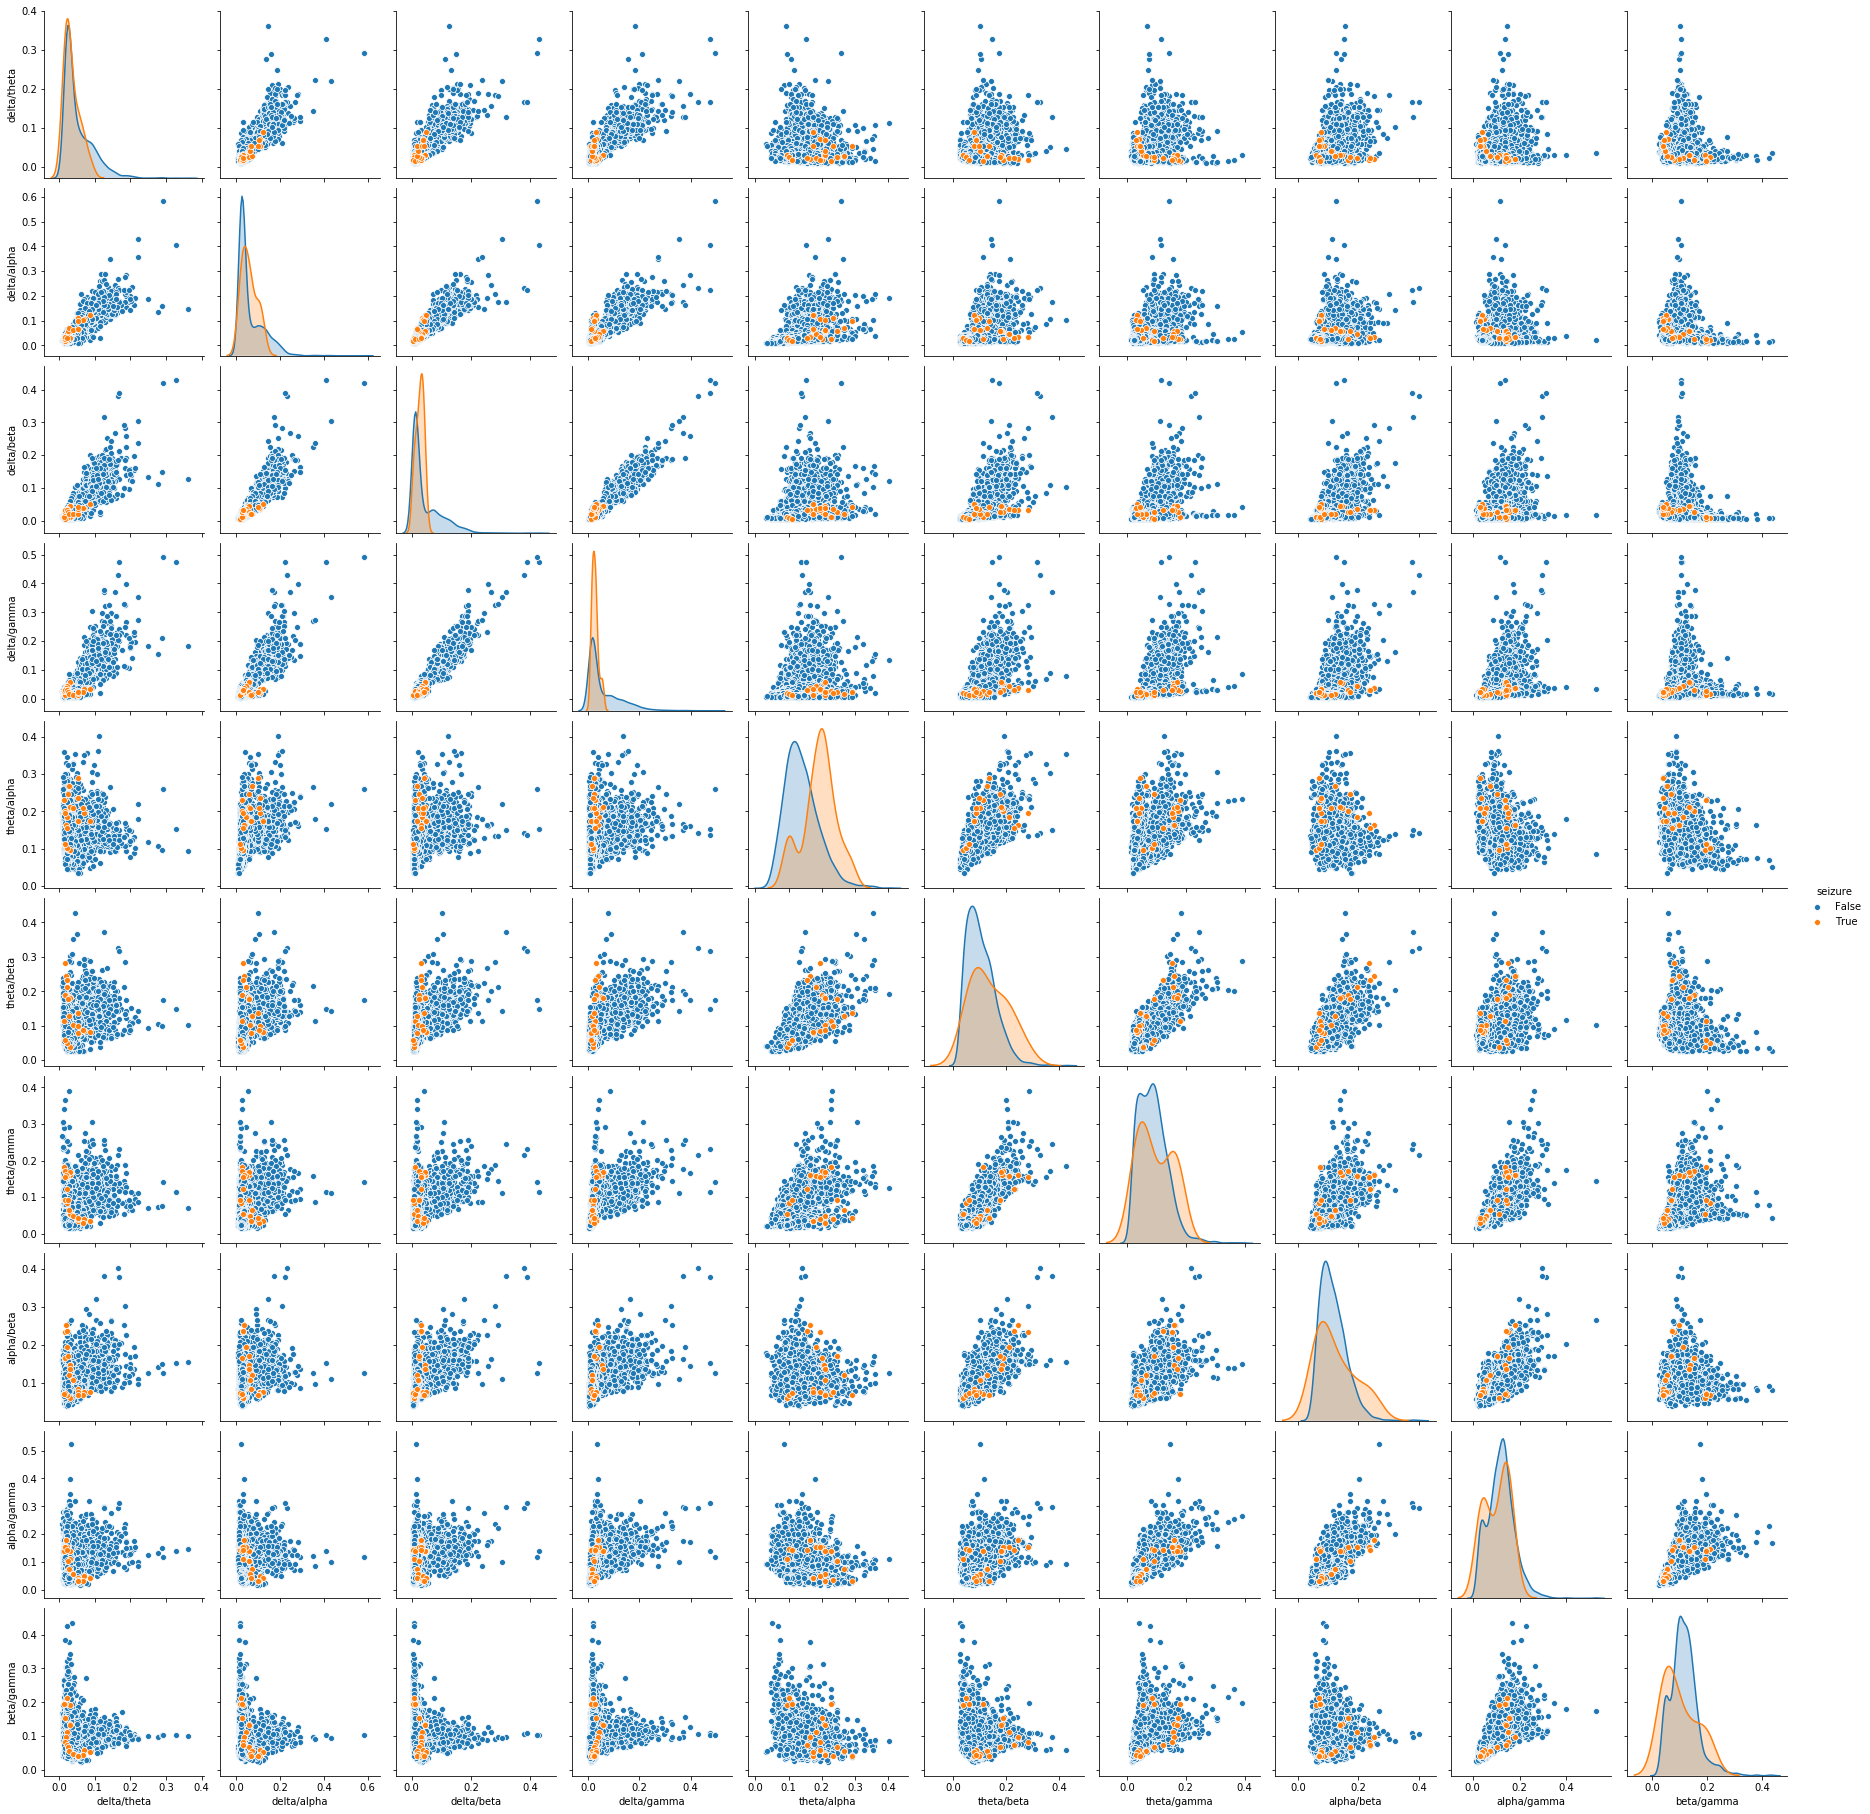

[40. 28. 19. ... 73. 74. 51.]


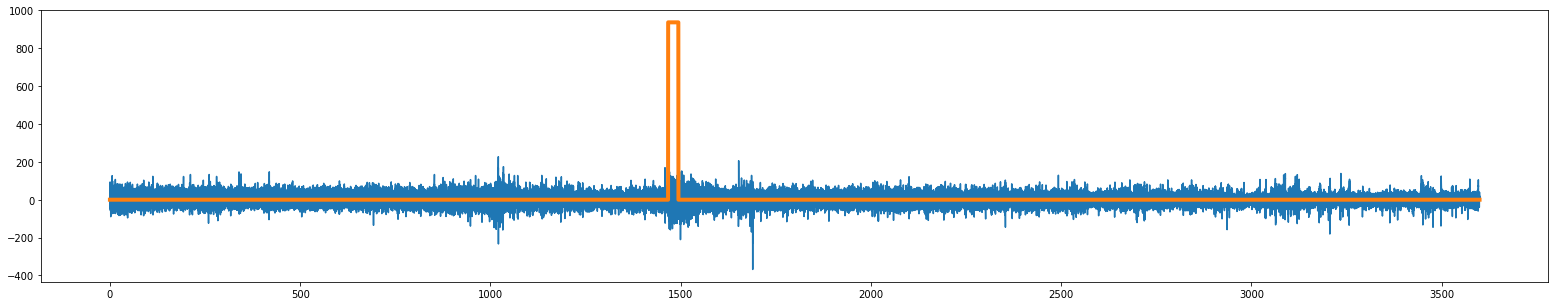

<Figure size 432x288 with 0 Axes>

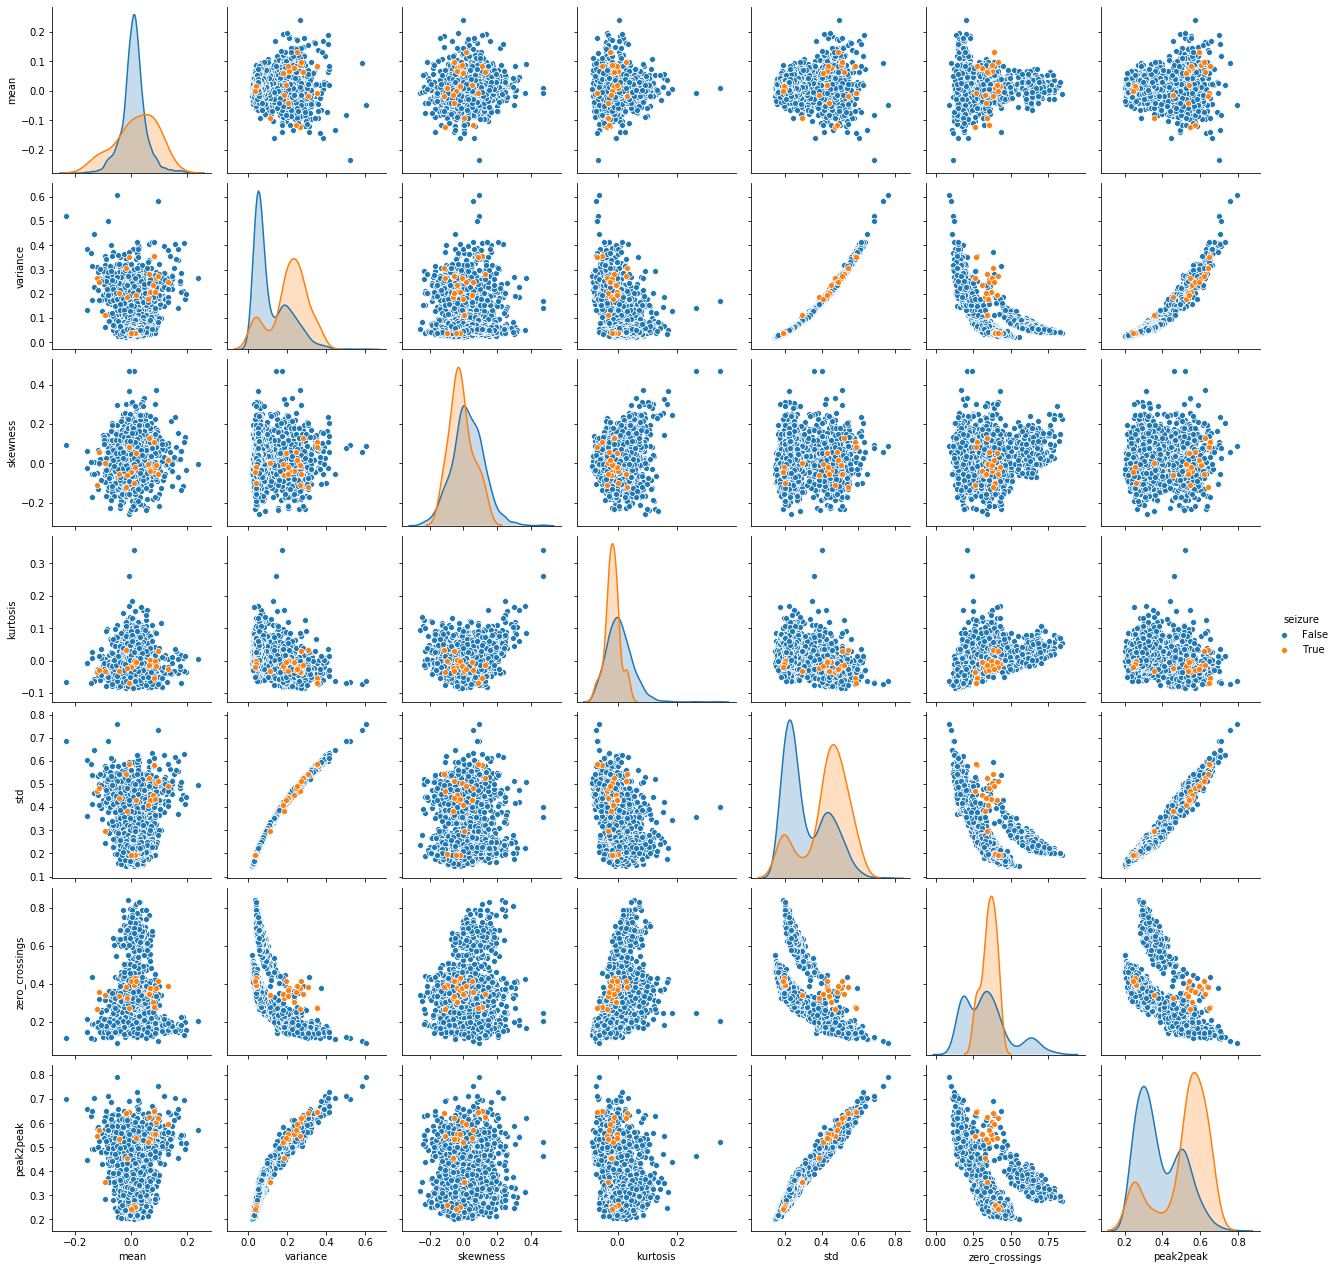

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [80]:
chunksize = nw
fdf = pd.DataFrame()
i = 0

for chunk in pd.read_hdf('E:\Master\TFM\Codigo\Jupiter\Test_EEG\example.h5', key = 'example', chunksize=chunksize):
    auxdf = chunk_processing(chunk, fs)
    plt.figure(figsize=(27,5))
    plt.plot(time, signals[i, :])
    plt.plot(time, seizure*np.amax(signals), linewidth=4)
    plt.show()
    
    
    plt.figure()
    seaborn.pairplot(auxdf[['mean', 'variance', 'skewness', 'kurtosis', 'std', 'zero_crossings', 'peak2peak', 'seizure']], hue="seizure")
    plt.show()
    
    plt.figure()
    seaborn.pairplot(auxdf[['total_energy', 'delta', 'theta', 'alpha', 'beta', 'gamma', 'spectral_centroid', 'variatonial_coeff', 'spectral_skew', 'seizure']], hue="seizure")
    plt.show()
    
    plt.figure()
    seaborn.pairplot(auxdf[['delta/theta', 'delta/alpha', 'delta/beta', 'delta/gamma', 'theta/alpha', 'theta/beta', 'theta/gamma','alpha/beta', 'alpha/gamma', 'beta/gamma', 'seizure']], hue="seizure")
    plt.show()
    i += 1
    #fdf = fdf.append(auxdf, ignore_index = True) 
    #print(fdf.shape)